```
Here in this colab file, I have executed 2 models 1. Custom token embedding  2. token + char + positional embedding 
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b688e33b-db2b-2393-91a7-b62830900111)


## Get the Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
!wget https://raw.githubusercontent.com/sarumangla/Multi-Tag-Assignment/master/helperfunctions.py

from helperfunctions import calculate_results,unzip_data,create_tensorboard_callback, plot_loss_curves

In [ ]:
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

In [ ]:
!cp "/content/train.txt" "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Becoming One with data

In [ ]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename(.txt) and returns the lines of text as a list.
    """
    with open(filename,'r') as f:
        return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [ ]:
len(train_lines)

2593169

## Preprocessing data

In [ ]:
def preprocess_text(filename):
    """
    Returns a list of dictionary of abstract line data
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()

            for abstract_ln_no, abstract_ln in enumerate(abstract_lines_split):
                data = {}
                target_text_split = abstract_ln.split("\t")
                data["target"] = target_text_split[0]
                data["text"] = target_text_split[1].lower()
                data["line_number"] = abstract_ln_no
                data["total_lines"] = len(abstract_lines_split) - 1
                abstract_samples.append(data)
        else:
            abstract_lines += line

    return abstract_samples

In [ ]:
val_samples = preprocess_text(data_dir + "dev.txt")
train_samples = preprocess_text(data_dir + "train.txt")
test_samples = preprocess_text(data_dir + "test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

2211861 28932 29493


In [ ]:
train_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'total_lines': 10},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'total_lines': 10},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'total_lines': 10},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'total_lines': 10},
 {'line_number': 4,
  'tar

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [ ]:
# distrubution of labels in training Data
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

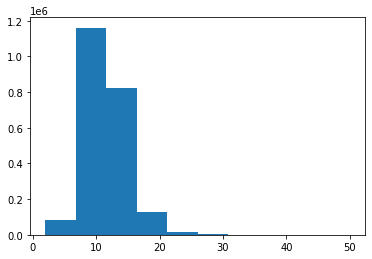

In [ ]:
# Let's Check the length of different lines
train_df.total_lines.hist(grid = False)

### Get list of Sentences

In [ ]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()
print(len(train_sen),len(val_sen),len(test_sen))

2211861 28932 29493


In [ ]:
train_sen[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

### Make Labels (One Hot Encoded and Numerical Encoded)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_oh = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_oh = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_oh = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_oh

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Numeric Encoded Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

### Model 0: MultiNomial Naive Bayes TF-IDF (Baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sen, y = train_labels_encoded);

In [ ]:
## Gives Accuracy on Validation Dataset
model_0.score(X = val_sen,
                 y = val_labels_encoded)

0.7497580533665146

In [ ]:
## Make Predictions
baseline_preds = model_0.predict(val_sen)
baseline_preds

array([0, 4, 4, ..., 4, 4, 1])

In [ ]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 74.97580533665146,
 'f1': 0.7389570175489825,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146}

### Text Vectorization Layer

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# How long is each sentence?
sen_lens = [len(sentence.split()) for sentence in train_sen]
avg_sen_len = np.mean(sen_lens)
avg_sen_len

26.229355280462922

(array([6.656900e+05, 1.064939e+06, 3.491070e+05, 9.095700e+04,
        2.651300e+04, 8.980000e+03, 3.125000e+03, 1.374000e+03,
        5.800000e+02, 2.770000e+02, 1.350000e+02, 7.100000e+01,
        5.200000e+01, 2.400000e+01, 1.900000e+01, 6.000000e+00,
        4.000000e+00, 5.000000e+00, 1.000000e+00, 2.000000e+00]),
 array([  1.  ,  17.85,  34.7 ,  51.55,  68.4 ,  85.25, 102.1 , 118.95,
        135.8 , 152.65, 169.5 , 186.35, 203.2 , 220.05, 236.9 , 253.75,
        270.6 , 287.45, 304.3 , 321.15, 338.  ]),
 <a list of 20 Patch objects>)

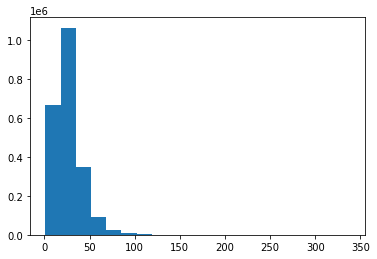

In [ ]:
# Distribution of sentences length
import matplotlib.pyplot as plt
plt.hist(sen_lens,bins = 20)

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sen_lens,95))
output_seq_len

54

In [ ]:
max(sen_lens)

338

```
# How many words are in our vocab? (taken from table 3.2 in : https://arxiv.org/pdf/1710.06071.pdf)

```

In [ ]:
max_tokens = 331000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
train_sen_dataset = tf.data.Dataset.from_tensor_slices(train_sen)
train_sen_dataset = train_sen_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_sen_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [ ]:
text_vectorizer.adapt(train_sen_dataset)

In [ ]:
import random
target_sen = random.choice(train_sen)
print(f"Text:\n{target_sen}")
print(f"\nLength of text : {len(target_sen.split())}")
print(f"\nVectorized text : {text_vectorizer([target_sen])}")

Text:
patients were randomly assigned to one of three anesthetic regimens .

Length of text : 11

Vectorized text : [[  11    9   87  119    6   76    3  105 1062  625    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocab
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 247961
Most common words in vocab: ['', '[UNK]', 'the', 'of', 'and']
Least common words in vocab: ['aaae', 'aaacp', 'aaabbb', 'aaaanalog', 'aaaa']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 331000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create Custom Embedding layer

In [ ]:
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [ ]:
print(f"Sentence before vectorization:\n{target_sen}")
vectorized_sen = text_vectorizer([target_sen])
print(f"Sentence after vectorization(before embedding):\n{vectorized_sen}")
embedded_sen = token_embed(vectorized_sen)
print(f"Sentence after embedding):\n{embedded_sen}\n")
print(f"Embedded Sentence shape : {embedded_sen.shape}")

Sentence before vectorization:
patients were randomly assigned to one of three anesthetic regimens .
Sentence after vectorization(before embedding):
[[  11    9   87  119    6   76    3  105 1062  625    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding):
[[[-0.01692412  0.00327094  0.04333505 ...  0.01938673  0.04497775
   -0.01004343]
  [-0.0402387   0.04611928  0.01593146 ...  0.00364914 -0.02977403
   -0.02528297]
  [-0.02504596  0.03517694 -0.01293303 ... -0.00265611 -0.0328487
    0.01765439]
  ...
  [-0.02669137  0.00213108 -0.02973375 ... -0.0033345   0.01167866
   -0.04834055]
  [-0.02669137  0.00213108 -0.02973375 ... -0.0033345   0.01167866
   -0.04834055]
  [-0.02669137  0.00213108 -0.02973375 ... -0.0033345   0.01167866
   -0.04834055]]]

Embedded Sentence shape : (1, 54, 128)

### Creating Datasets For our Model 1

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen,train_labels_oh))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen,val_labels_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen,test_labels_oh))
 
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1 : Conv1D with custom Token Embeddings

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 54, 128)          31739008  
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0     

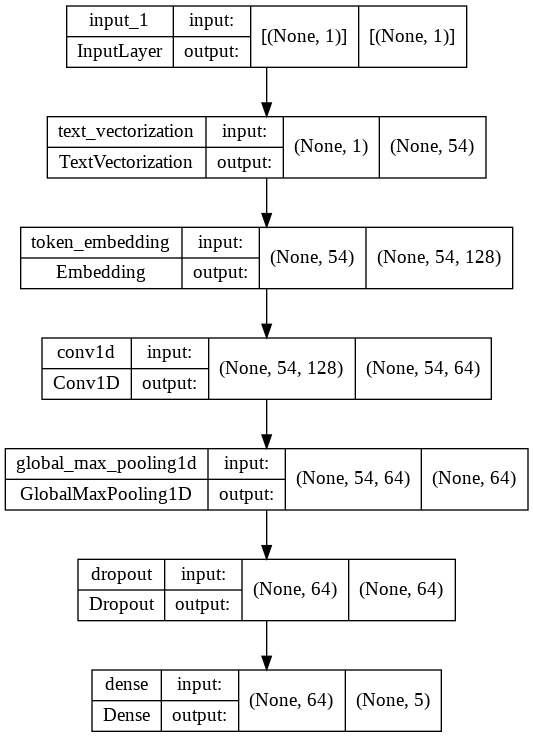

In [ ]:
tf.keras.utils.plot_model(model_1,show_shapes=True)

#### Training Model 1

In [ ]:
run_dir = "/content/drive/MyDrive/PubMed/Checkpoints/Model1/"
checkpoint_path = os.path.join(run_dir,'model-{epoch:02d}-{val_loss:02f}.ckpt')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy")

In [ ]:
model_1.save_weights(checkpoint_path.format(epoch=0,val_loss=0.00))

In [ ]:
history_model_1 = model_1.fit(
    train_dataset,
    epochs = 5,
    steps_per_epoch = int(0.2 * len(train_dataset)),
    validation_data = valid_dataset,
    validation_steps = int(0.1*len(valid_dataset)),
    callbacks = [checkpoint_callback]
)

Epoch 1/5
13824/13824 [==============================] - 290s 21ms/step - loss: 0.4482 - accuracy: 0.8417 - val_loss: 0.4843 - val_accuracy: 0.8285
Epoch 2/5
13824/13824 [==============================] - 279s 20ms/step - loss: 0.5217 - accuracy: 0.8152 - val_loss: 0.4449 - val_accuracy: 0.8378
Epoch 3/5
13824/13824 [==============================] - 281s 20ms/step - loss: 0.5121 - accuracy: 0.8189 - val_loss: 0.4477 - val_accuracy: 0.8354
Epoch 4/5
13824/13824 [==============================] - 280s 20ms/step - loss: 0.5055 - accuracy: 0.8208 - val_loss: 0.4386 - val_accuracy: 0.8361
Epoch 5/5
13824/13824 [==============================] - 280s 20ms/step - loss: 0.5027 - accuracy: 0.8220 - val_loss: 0.4299 - val_accuracy: 0.8424


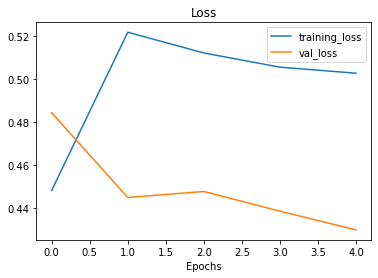

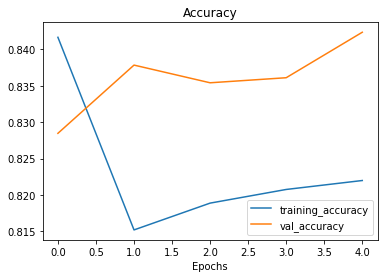

In [ ]:
plot_loss_curves(history_model_1)

In [ ]:
model_1.evaluate(valid_dataset)

905/905 [==============================] - 3s 3ms/step - loss: 0.4280 - accuracy: 0.8453


[0.4279767870903015, 0.8452578186988831]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

(28932, 5)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs,axis = 1)
model_1_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 1, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_pred=model_1_preds,
                                    y_true = val_labels_encoded)
model_1_results

{'accuracy': 84.52578459836859,
 'f1': 0.842549447628614,
 'precision': 0.8417870067819809,
 'recall': 0.8452578459836859}

### Loading Model 1

In [ ]:
run_dir = "/content/drive/MyDrive/PubMed/Checkpoints/Model1/"
checkpoint_path = os.path.join(run_dir,'model-{epoch:02d}-{val_loss:02f}.ckpt')

checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

model = tf.keras.Model(inputs,outputs)

model.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model.load_weights(latest)

model.evaluate(valid_dataset)

### PreTrained Token Embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    name = "USE"
)

In [ ]:
import random
random_train_sen = random.choice(train_sen)
print(f"Random sentence:\n {random_train_sen}")
use_embedded_sen = tf_hub_embedding_layer([random_train_sen])
print(f"Sentence after embedding :\n{use_embedded_sen[0][:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sen[0])}")

Random sentence:
 we aimed to assess the effect of rasagiline on symptoms and progression of the parkinsonian variant of multiple system atrophy .
Sentence after embedding :
[-0.00808954 -0.03442345 -0.03949891 -0.06611577 -0.03951962  0.01623381
 -0.04722618 -0.02232587  0.08761942  0.05452972  0.09264178  0.01889023
  0.07815763  0.0920574  -0.02332161 -0.00520592 -0.08049908 -0.00503955
  0.01133698 -0.00822215]

Length of sentence embedding: 512


### Creating Character Vectorization Layer

In [ ]:
def split_to_chars(text):
    return " ".join(list(text))

In [ ]:
train_chars = [split_to_chars(sentence) for sentence in train_sen]
val_chars = [split_to_chars(sentence) for sentence in val_sen]
test_chars = [split_to_chars(sentence) for sentence in test_sen]

test_chars[:5]

['m a n y   p a t h o g e n i c   p r o c e s s e s   a n d   d i s e a s e s   a r e   t h e   r e s u l t   o f   a n   e r r o n e o u s   a c t i v a t i o n   o f   t h e   c o m p l e m e n t   c a s c a d e   a n d   a   n u m b e r   o f   i n h i b i t o r s   o f   c o m p l e m e n t   h a v e   t h u s   b e e n   e x a m i n e d   f o r   a n t i - i n f l a m m a t o r y   a c t i o n s   .',
 'i t   w a s   r e c e n t l y   d e m o n s t r a t e d   t h a t   s u p r a p h y s i o l o g i c a l   c o n c e n t r a t i o n s   o f   t h e   e n d o g e n o u s   c o m p l e m e n t   i n h i b i t o r   m a p @   (   a l s o   d e n o t e d   m a p @   )   p r o t e c t   a g a i n s t   m y o c a r d i a l   r e p e r f u s i o n   i n j u r y   .',
 'i n   t h e   p r e s e n t   s t u d y   ,   w e   e x a m i n e d   t h e   a s s o c i a t i o n   b e t w e e n   o u t c o m e   a f t e r   a c u t e   m y o c a r d i a l   i n f a r c t i o n   (   m i   )   a n d 

In [ ]:
# Avg character length
import numpy as np

char_lens = [len(sentence) for sentence in train_sen]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

(array([2.030236e+06, 1.779350e+05, 3.470000e+03, 1.980000e+02,
        2.000000e+01, 1.000000e+00, 1.000000e+00]),
 array([1.00000000e+00, 2.54428571e+02, 5.07857143e+02, 7.61285714e+02,
        1.01471429e+03, 1.26814286e+03, 1.52157143e+03, 1.77500000e+03]),
 <a list of 7 Patch objects>)

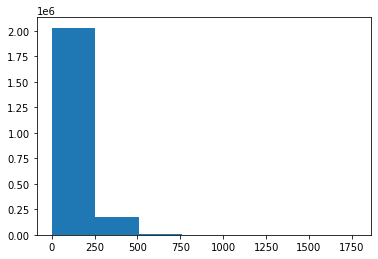

In [ ]:
# Check distribution

import matplotlib.pyplot as plt
plt.hist(char_lens,bins = 7)

In [ ]:
# What character length covers 95% of the lengths?
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

284

In [ ]:
# Get all keyboard characters
import string
alphabet=  string.ascii_lowercase + string.digits+ string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Char level token vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

num_char_tokens = len(alphabet) + 2 # for space and UNK(Unkown)
char_vectorizer = TextVectorization(
    max_tokens = num_char_tokens,
    output_sequence_length = output_seq_char_len,
    name = "char_vectorizer"
)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices(train_chars)
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [ ]:
char_vectorizer.adapt(train_char_dataset)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab : {len(char_vocab)}")
print(f"5 most common characters : {char_vocab[:5]}")
print(f"5 least common characters : {char_vocab[-5:]}")

Number of different characters in character vocab : 28
5 most common characters : ['', '[UNK]', 'e', 't', 'a']
5 least common characters : ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text : \n{random_train_chars}")
print(f"\nLength of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars : \n{vectorized_chars}")
print(f"length of vectorized chars : {len(vectorized_chars[0])}")

Charified text : 
m o n t e l u k a s t   m a y   b e   a   w e l l - t o l e r a t e d   a n d   e f f e c t i v e   t h e r a p e u t i c   o p t i o n   i n   @   t o   @ - y e a r - o l d   p a t i e n t s   w i t h   m i l d   p e r s i s t e n t   a s t h m a   .

Length of random_train_chars : 108

Vectorized chars : 
[[15  7  6  3  2 11 16 23  4  9  3 15  4 19 22  2  4 20  2 11 11  3  7 11
   2  8  4  3  2 10  4  6 10  2 17 17  2 12  3  5 21  2  3 13  2  8  4 14
   2 16  3  5 12  7 14  3  5  7  6  5  6  3  7 19  2  4  8  7 11 10 14  4
   3  5  2  6  3  9 20  5  3 13 15  5 11 10 14  2  8  9  5  9  3  2  6  3
   4  9  3 13 15  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0

### Create Custom Character Embedding Layer

In [ ]:
char_embed = layers.Embedding(
    input_dim=len(char_vocab),
    output_dim = 25, # From paper
    mask_zero = False,
    name = "char_embed"
)

In [ ]:
print(f"Charified text : \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embediing) : \n{char_embed_example}\n")
print(f"Character Embediing shape : {char_embed_example.shape}")

Charified text : 
m o n t e l u k a s t   m a y   b e   a   w e l l - t o l e r a t e d   a n d   e f f e c t i v e   t h e r a p e u t i c   o p t i o n   i n   @   t o   @ - y e a r - o l d   p a t i e n t s   w i t h   m i l d   p e r s i s t e n t   a s t h m a   .

Embedded chars (after vectorization and embediing) : 
[[[ 0.00583391  0.04998305 -0.03748546 ... -0.00188385 -0.04466804
    0.03068626]
  [ 0.03922478  0.01380214  0.04407493 ...  0.04466847  0.00192391
   -0.00847838]
  [ 0.01306652 -0.03104612 -0.00607387 ...  0.00618943 -0.03170846
    0.00151635]
  ...
  [-0.03695349 -0.03601331  0.01391498 ... -0.00826678  0.04506515
    0.00536103]
  [-0.03695349 -0.03601331  0.01391498 ... -0.00826678  0.04506515
    0.00536103]
  [-0.03695349 -0.03601331  0.01391498 ... -0.00826678  0.04506515
    0.00536103]]]

Character Embediing shape : (1, 284, 25)


### Create Positional Embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: line_number, dtype: int64

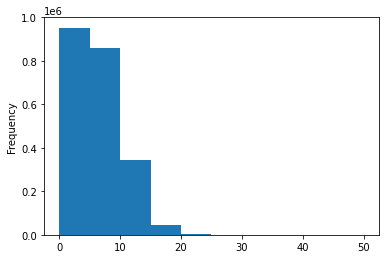

In [ ]:
# Check the distribution of column
train_df.line_number.plot.hist()

In [ ]:
train_line_no_oh = tf.one_hot(train_df["line_number"].to_numpy(),depth= 15)
val_line_no_oh = tf.one_hot(val_df["line_number"].to_numpy(),depth= 15)
test_line_no_oh = tf.one_hot(test_df["line_number"].to_numpy(),depth= 15)
train_line_no_oh[:10],train_line_no_oh.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([2211861, 15]))

In [ ]:
# How many different total line values are there?
train_df["total_lines"].value_counts()

10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: total_lines, dtype: int64

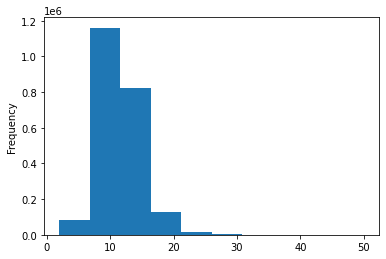

In [ ]:
# Check the distribution
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines,95), np.percentile(train_df.total_lines,98)

(17.0, 20.0)

In [ ]:
train_total_lines_no_oh = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_no_oh = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_no_oh = tf.one_hot(test_df["total_lines"].to_numpy(),depth= 20)
train_total_lines_no_oh[:10],train_total_lines_no_oh.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0

### Creating datasets for model 2

In [ ]:
final_train_data = tf.data.Dataset.from_tensor_slices((train_line_no_oh,train_total_lines_no_oh,train_sen,train_chars))
final_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
final_train_dataset = tf.data.Dataset.zip((final_train_data,final_train_labels))

final_train_dataset = final_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
final_val_data = tf.data.Dataset.from_tensor_slices((val_line_no_oh,val_total_lines_no_oh,val_sen,val_chars))
final_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
final_val_dataset = tf.data.Dataset.zip((final_val_data,final_val_labels))

final_val_dataset = final_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_val_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
final_test_data = tf.data.Dataset.from_tensor_slices((test_line_no_oh,test_total_lines_no_oh,test_sen,test_chars))
final_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
final_test_dataset = tf.data.Dataset.zip((final_test_data,final_test_labels))

final_test_dataset = final_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_test_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 2 : Transfer learning with pretrained token embediings + character embeddings + positional embediings

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype = tf.string,name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(256,activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [ ]:
# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype = tf.string,name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [ ]:
# 3. Line Number Model
line_no_inputs = layers.Input(shape=(15,),dtype = tf.float32,name="line_no_inputs")
x = layers.Dense(32,activation="relu")(line_no_inputs)
line_no_model = tf.keras.Model(inputs = line_no_inputs,
                               outputs = x)

In [ ]:
# 4. Total Line Number Model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                      outputs = y)

In [ ]:
# 5. Combine 1 and 2 into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

In [ ]:
# 6. 
z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [ ]:
# 7. Combine positional embediing with 5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_no_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

In [ ]:
# 8. Create output layer
output_layer = layers.Dense(num_classes,activation="softmax",name = "output_layer")(tribrid_embeddings)

In [ ]:
# 9. Put together model with all kinds of inputs
model_2 = tf.keras.Model(
    inputs=[
            line_no_model.input,
            total_lines_model.input,
            token_model.input,
            char_model.input
    ],
    outputs=output_layer,
    name = "tribrid_embedding_model"
)

In [ ]:
model_2.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inp

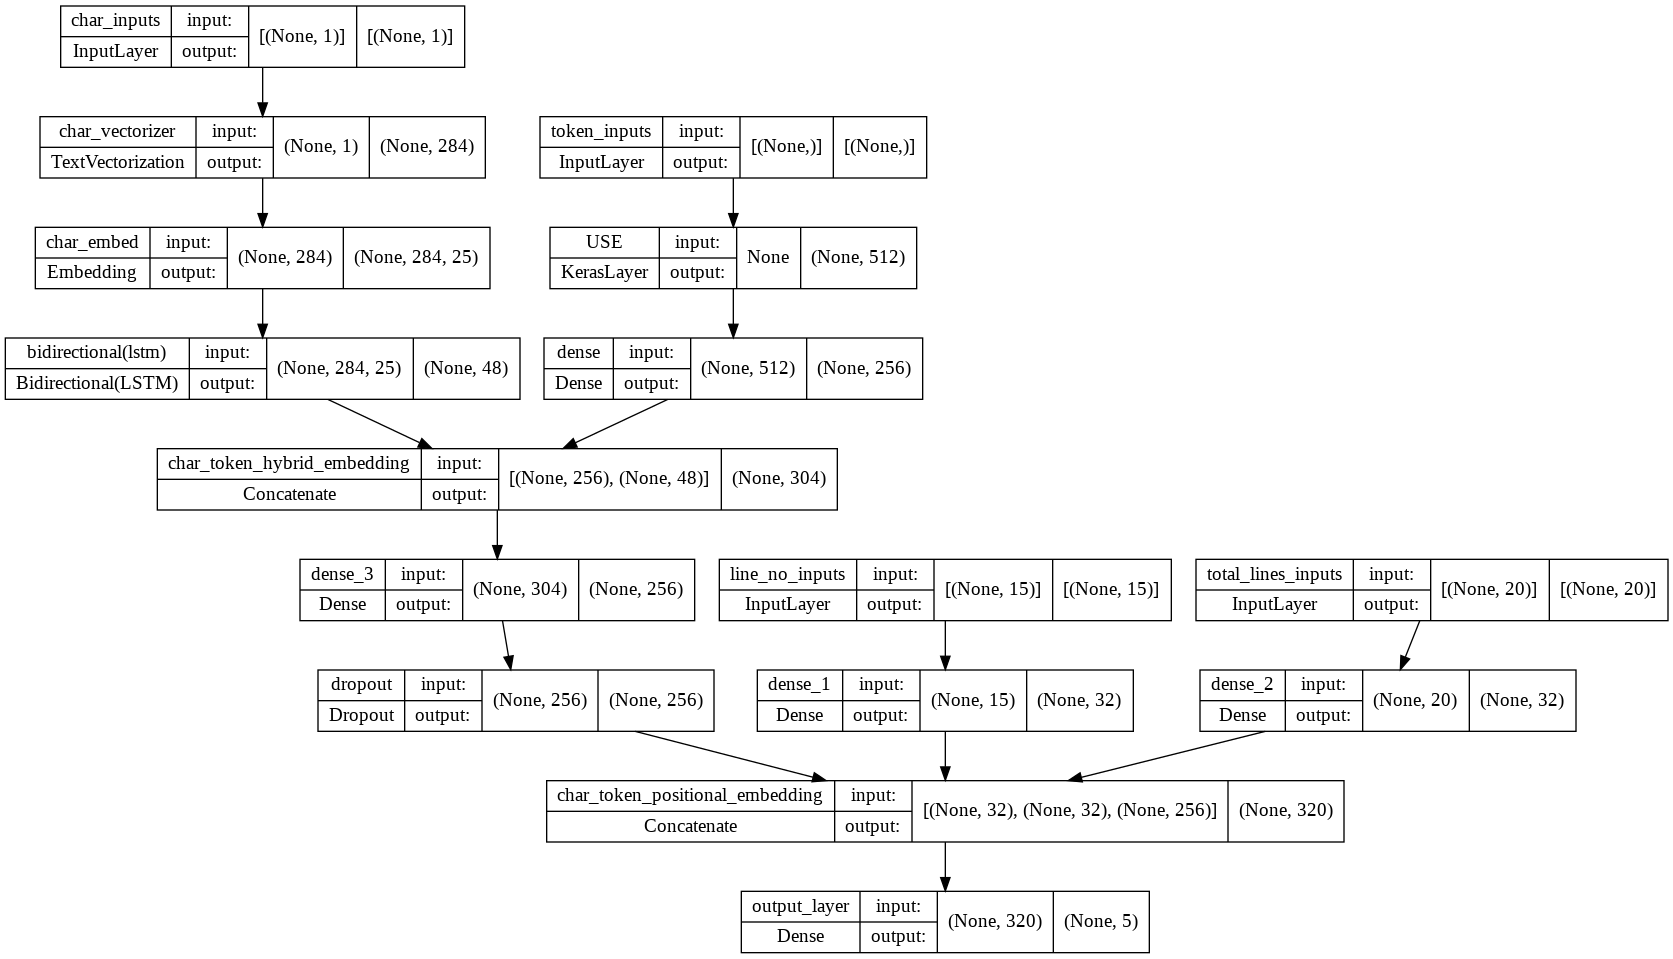

In [ ]:
tf.keras.utils.plot_model(model_2,show_shapes = True)

In [ ]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Training Model 2

In [ ]:
run_dir = "/content/drive/MyDrive/PubMed/Checkpoints/Model2/"
checkpoint_path = os.path.join(run_dir,'model-{epoch:02d}-{val_loss:02f}.ckpt')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy")

In [ ]:
model_2.save_weights(checkpoint_path.format(epoch=0,val_loss=0.00))

In [ ]:
history_model_2 = model_2.fit(
    final_train_dataset,
    epochs = 4,
    steps_per_epoch = int(0.2 * len(final_train_dataset)),
    validation_data = final_val_dataset,
    validation_steps = int(0.2 * len(final_val_dataset)),
    callbacks = [checkpoint_callback,create_tensorboard_callback("PubMedAbstracts","model_2_Tribrid")]
)

Saving TensorBoard log files to: PubMedAbstracts/model_2_Tribrid/20220703-161759
Epoch 1/8
13824/13824 [==============================] - 482s 34ms/step - loss: 0.9220 - accuracy: 0.8419 - val_loss: 0.8888 - val_accuracy: 0.8674
Epoch 2/8
13824/13824 [==============================] - 474s 34ms/step - loss: 0.8981 - accuracy: 0.8590 - val_loss: 0.8782 - val_accuracy: 0.8696
Epoch 3/8
13824/13824 [==============================] - 468s 34ms/step - loss: 0.8921 - accuracy: 0.8638 - val_loss: 0.8766 - val_accuracy: 0.8759
Epoch 4/8
13824/13824 [==============================] - 481s 35ms/step - loss: 0.8892 - accuracy: 0.8653 - val_loss: 0.8707 - val_accuracy: 0.8752
Epoch 5/8
13824/13824 [==============================] - 473s 34ms/step - loss: 0.8867 - accuracy: 0.8669 - val_loss: 0.8685 - val_accuracy: 0.8776
Epoch 6/8
    1/13824 [..............................] - ETA: 29:11 - loss: 1.1963 - accuracy: 0.7143WARNING:tensorflow:Your input ran out of data; interrupting training. Make sur

13824/13824 [==============================] - 11s 786us/step - loss: 1.1963 - accuracy: 0.7143 - val_loss: 0.8686 - val_accuracy: 0.8776


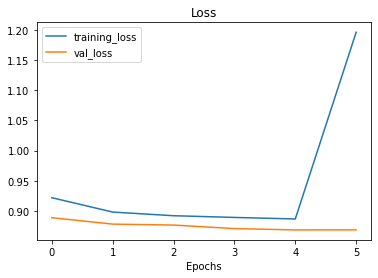

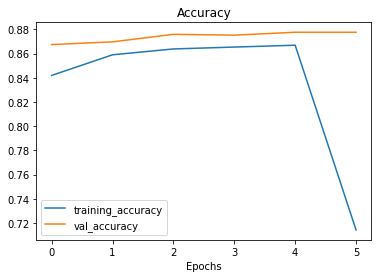

In [ ]:
plot_loss_curves(history_model_2)   

In [ ]:
model_2.evaluate(final_val_dataset)

905/905 [==============================] - 20s 22ms/step - loss: 0.8717 - accuracy: 0.8734


[0.8717097043991089, 0.8734273314476013]

In [ ]:
model_2_pred_probs = model_2.predict(final_val_dataset,verbose = 1)
model_2_pred_probs

905/905 [==============================] - 20s 20ms/step


array([[0.6032613 , 0.07596014, 0.02109765, 0.2057651 , 0.09391581],
       [0.17835152, 0.05637062, 0.53189176, 0.14378005, 0.08960597],
       [0.2173466 , 0.06742144, 0.12350743, 0.13136552, 0.46035898],
       ...,
       [0.05464381, 0.4273169 , 0.04814114, 0.05174817, 0.41815   ],
       [0.03892323, 0.4010786 , 0.03513567, 0.04279232, 0.48207018],
       [0.04334851, 0.84735656, 0.02474161, 0.02641438, 0.05813896]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 1, 4, 1])>

In [ ]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_2_preds)
model_2_results

{'accuracy': 87.34273468823449,
 'f1': 0.8718500149406635,
 'precision': 0.8753639087836202,
 'recall': 0.8734273468823448}

### Load Model 2

In [ ]:
run_dir = "/content/drive/MyDrive/PubMed/Checkpoints/Model2/"
checkpoint_path = os.path.join(run_dir,'model-{epoch:02d}-{val_loss:02f}.ckpt')

checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

model = tf.keras.Model(
    inputs=[
            line_no_model.input,
            total_lines_model.input,
            token_model.input,
            char_model.input
    ],
    outputs=output_layer,
    name = "tribrid_embedding_model"
)


model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model.load_weights(latest)
model.evaluate(final_val_dataset)

905/905 [==============================] - 23s 23ms/step - loss: 0.8717 - accuracy: 0.8734


[0.8717097043991089, 0.8734273314476013]

## Save Model

In [ ]:
model.save("/content/drive/MyDrive/PubMed/pubmed_200k_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PubMed/pubmed_200k_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PubMed/pubmed_200k_model/assets


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
model_path = "/content/drive/MyDrive/PubMed/pubmed_200k_model"
model = tf.keras.models.load_model(model_path,custom_objects={"TextVectorization": TextVectorization,"KerasLayer": hub.KerasLayer})

In [ ]:
pred_probs = loaded_model.predict(final_val_dataset, verbose=1)
preds = tf.argmax(loaded_pred_probs, axis=1)

905/905 [==============================] - 19s 21ms/step


In [ ]:
model.evaluate(final_val_dataset)

905/905 [==============================] - 21s 21ms/step - loss: 0.8724 - accuracy: 0.8722


[0.8724027276039124, 0.87221759557724]

## Compare Model Results

In [ ]:
model_results = pd.DataFrame(
    {
        "model_0_baseline": baseline_results,
        "model_1_custom_token_embed_conv1d": model_1_results,
        "model_2_tribrid_pos_char_token_embed": model_2_results
    }
)

model_results = model_results.transpose()
model_results

,accuracy,precision,recall,f1
model_0_baseline,74.975805,0.743197,0.749758,0.738957
model_1_custom_token_embed_conv1d,84.525785,0.841787,0.845258,0.842549
model_2_tribrid_pos_char_token_embed,87.221761,0.874084,0.872218,0.870691


In [ ]:
model_results["accuracy"] = model_results["accuracy"]/100

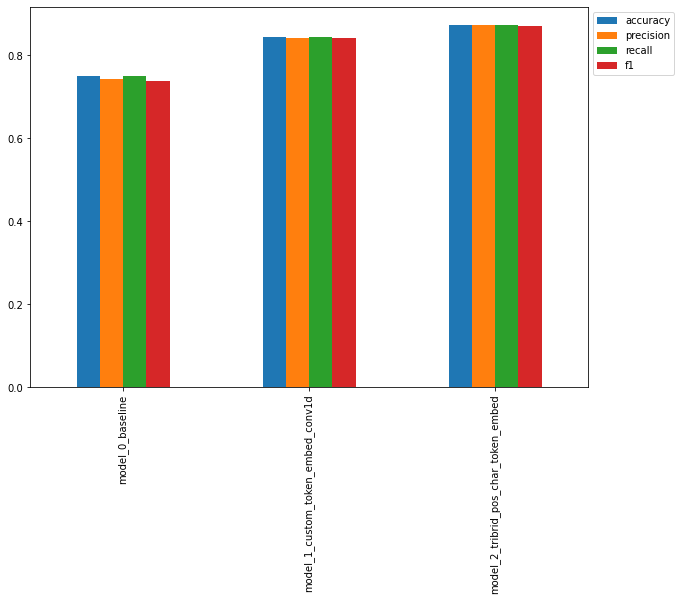

In [ ]:
model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

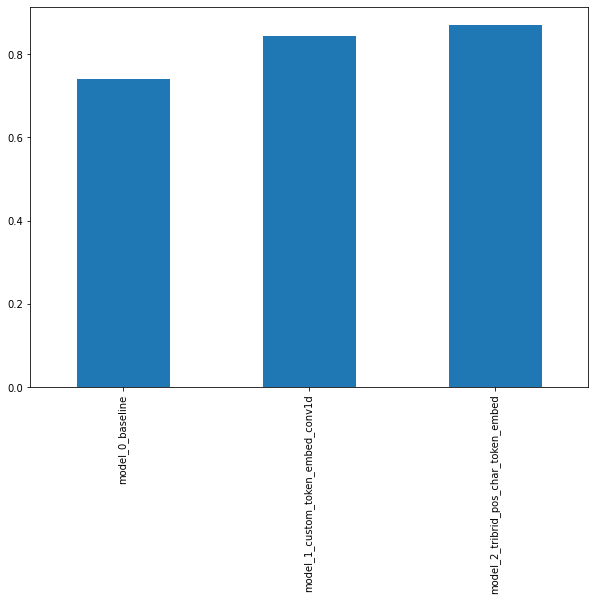

In [ ]:
model_results.sort_values("f1",ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

## Evaluate Model on test data

In [ ]:
test_pred_probs = model_2.predict(final_test_dataset,verbose = 1)
test_preds = tf.argmax(test_pred_probs,axis = 1)
test_preds

922/922 [==============================] - 24s 26ms/step


<tf.Tensor: shape=(29493,), dtype=int64, numpy=array([0, 0, 2, ..., 4, 1, 1])>

In [ ]:
test_results = calculate_results(y_true = test_labels_encoded,
                                 y_pred = test_preds)
test_results

{'accuracy': 87.11219611433222,
 'f1': 0.869409470729858,
 'precision': 0.8716776917512283,
 'recall': 0.8711219611433222}

## Find Most Wrong predictions

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
print(test_pred_classes[:5])

['BACKGROUND', 'BACKGROUND', 'METHODS', 'METHODS', 'RESULTS']


In [ ]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10,BACKGROUND,0.643595,True
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10,BACKGROUND,0.734454,True
2,BACKGROUND,"in the present study , we examined the associa...",2,10,METHODS,0.535263,False
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10,METHODS,0.800324,False
4,METHODS,a total of @ mi patients and @ control persons...,4,10,RESULTS,0.591367,False
5,METHODS,plasma samples were obtained and analysed with...,5,10,METHODS,0.828752,True
6,METHODS,the myocardial outcomes ( salvage index and fi...,6,10,METHODS,0.665784,True
7,RESULTS,mi patients had @ % higher plasma levels of ma...,7,10,RESULTS,0.875644,True
8,RESULTS,"however , neither salvage index ( spearman rho...",8,10,RESULTS,0.856463,True
9,RESULTS,"likewise , masp-@ and masp-@ were elevated in ...",9,10,RESULTS,0.829497,True


In [ ]:
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
24135,CONCLUSIONS,national clinical trials registry nct@ .,11,11,BACKGROUND,0.974232,False
13239,CONCLUSIONS,isrctn@ . ),14,14,BACKGROUND,0.948156,False
4057,CONCLUSIONS,unique identifier : isrctn@ .,7,7,BACKGROUND,0.925466,False
9159,BACKGROUND,to examine the prognostic value of markers of ...,0,8,OBJECTIVE,0.905588,False
13897,RESULTS,"costs were assessed from a us perspective , an...",3,13,METHODS,0.904307,False
16945,RESULTS,"randomization , stratified by site ( @ public ...",4,21,METHODS,0.903307,False
17639,RESULTS,it was carried out in communities based in two...,2,13,METHODS,0.901451,False
19062,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,21,21,BACKGROUND,0.900762,False
26363,RESULTS,the patients in both groups were treated by ch...,4,16,METHODS,0.898969,False
22501,CONCLUSIONS,stone expulsion rate was significantly high in...,8,11,RESULTS,0.897555,False


## Make Example Predictions

In [ ]:
from itertools import groupby, chain
import json
import nltk
from nltk import tokenize
import nltk.data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def prepro(example_abstract):
    grouped = groupby(example_abstract, str.isdigit)
    processed_abstract = ''.join(chain.from_iterable("@" if k else g for k,g in grouped))
    return processed_abstract

In [ ]:
import re
alphabets= "([A-Za-z])"
digits = "([0-9])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [ ]:
# Get total number of lines
def make_dict(abstract_lines):
    total_lines_in_sample = len(abstract_lines)

    # Go through each line in abstract and create a list of dictionaries containing features for each line
    sample_lines = []
    for i, line in enumerate(abstract_lines):
        sample_dict = {}
        sample_dict["text"] = str(line)
        sample_dict["line_number"] = i
        sample_dict["total_lines"] = total_lines_in_sample - 1
        sample_lines.append(sample_dict)
    return sample_lines

In [ ]:
def to_chars(example_abstract):
    abstract_chars = [split_to_chars(sentence) for sentence in example_abstract]
    return abstract_chars

In [ ]:
def encode_line_numbers(sample):
    test_abstract_line_numbers = [line["line_number"] for line in sample]
    test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
    return test_abstract_line_numbers_one_hot

In [ ]:
def encode_total_line_numbers(sample):
    test_abstract_total_lines = [line["total_lines"] for line in sample]
    test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
    return test_abstract_total_lines_one_hot

In [ ]:
def make_predictions(document):
  actual_sentence = split_into_sentences(document)
  processed_abstract = prepro(document)
  sentences = split_into_sentences(processed_abstract)
  data = make_dict(sentences)
  characters = to_chars(sentences)
  lines_encoded = encode_line_numbers(data)
  total_lines_encoded = encode_total_line_numbers(data)
  
  pred_probs = model.predict(x=(lines_encoded,total_lines_encoded,tf.constant(sentences),tf.constant(characters)))

  predictions = tf.argmax(pred_probs, axis=1)
  pred_classes = [label_encoder.classes_[i] for i in predictions]

  
  for x in actual_sentence:
    print(x)

  print(
  '''
  ==============================CLASSIFYING==================================
  ''')

  for i, line in enumerate(actual_sentence):
    print(f"{pred_classes[i]}: {line}")

In [ ]:
!wget "https://raw.githubusercontent.com/sarumangla/Multi-Tag-Assignment/master/Example_Doc1.json"
!wget "https://raw.githubusercontent.com/sarumangla/Multi-Tag-Assignment/master/Example_Doc2.json"

In [ ]:
with open("/content/Example_Doc1.json","r") as f:
    doc = json.load(f)

In [ ]:
make_predictions(doc[0]["abstract"])

This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
Participants were randomly assigned to treatment or wait-list conditions.
Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

  ==============================CLASSIFYING==================================
  
OBJECTIVE: This RCT exa

In [ ]:
with open("/content/Example_Doc2.json","r") as f:
    doc = json.load(f)

In [ ]:
make_predictions(doc[0]["abstract"])

Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.
There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.
Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).
Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.
The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.
Any patient with HCV infection was selected for this analysis.
Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks.
With respect to the placebo group (3/12, 25.0%), a significa

In [ ]:
doc = "In mice, social defeat stress (SDS), an ethological model for psychosocial stress, induces sleep. Such sleep could enable resilience, but how stress promotes sleep is unclear. Activity-dependent tagging revealed a subset of ventral tegmental area γ-aminobutyric acid (GABA)-somatostatin (VTAVgat-Sst) cells that sense stress and drive non-rapid eye movement (NREM) and REM sleep through the lateral hypothalamus and also inhibit corticotropin-releasing factor (CRF) release in the paraventricular hypothalamus. Transient stress enhances the activity of VTAVgat-Sst cells for several hours, allowing them to exert their sleep effects persistently. Lesioning of VTAVgat-Sst cells abolished SDS-induced sleep; without it, anxiety and corticosterone concentrations remained increased after stress. Thus, a specific circuit allows animals to restore mental and body functions by sleeping, potentially providing a refined route for treating anxiety disorders."
make_predictions(doc)

In mice, social defeat stress (SDS), an ethological model for psychosocial stress, induces sleep.
Such sleep could enable resilience, but how stress promotes sleep is unclear.
Activity-dependent tagging revealed a subset of ventral tegmental area γ-aminobutyric acid (GABA)-somatostatin (VTAVgat-Sst) cells that sense stress and drive non-rapid eye movement (NREM) and REM sleep through the lateral hypothalamus and also inhibit corticotropin-releasing factor (CRF) release in the paraventricular hypothalamus.
Transient stress enhances the activity of VTAVgat-Sst cells for several hours, allowing them to exert their sleep effects persistently.
Lesioning of VTAVgat-Sst cells abolished SDS-induced sleep; without it, anxiety and corticosterone concentrations remained increased after stress.
Thus, a specific circuit allows animals to restore mental and body functions by sleeping, potentially providing a refined route for treating anxiety disorders.

  ==============================CLASSIFYING==